In [2]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    BartForSequenceClassification,
    BartTokenizer,
    AutoTokenizer,
    AutoModel,
    RobertaForSequenceClassification,
    RobertaTokenizer,
)
from tensorboardX import SummaryWriter
from tqdm import tqdm
import pickle
import random

In [3]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join('/private/000_kdigit/000_teamp/001_dataset/', file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in tqdm(f.readlines())]
        for item in tqdm(id_file_data):
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')
    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [4]:
model_arch = "bert"
if model_arch == "bert":
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
elif model_arch == "sci_bert":
    tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
    model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
elif model_arch == "bart":
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
    model = BartForSequenceClassification.from_pretrained('facebook/bart-large')
elif model_arch == "roberta": 
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    model = RobertaForSequenceClassification.from_pretrained('roberta-base')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [5]:
def cast_to_int(sample):
    return [int(word_id) for word_id in sample]

with open(os.path.join('/private/000_kdigit/000_teamp/001_dataset/', "sentiment.dev.1"), 'r', encoding='utf-8') as f:
    dev_sents = [line for line in tqdm(f.readlines())]
with open(os.path.join('/private/000_kdigit/000_teamp/001_dataset/', "sentiment.dev.0"), 'r', encoding='utf-8') as f:
    dev_sents += [line for line in tqdm(f.readlines())]
dev_sents = np.array(dev_sents)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 1419392.22it/s]


In [6]:
if os.path.isfile(f"{model_arch}_train_pos.pickle"):
    with open(f'{model_arch}_train_pos.pickle', 'rb') as f:
        train_pos = pickle.load(f)
    with open(f'{model_arch}_train_neg.pickle', 'rb') as f:
        train_neg = pickle.load(f)
    with open(f'{model_arch}_valid_pos.pickle', 'rb') as f:
        dev_pos = pickle.load(f)
    with open(f'{model_arch}_valid_neg.pickle', 'rb') as f:
        dev_neg = pickle.load(f)
else:
    train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)
    with open(f"{model_arch}_train_pos.pickle", "wb") as f:
        pickle.dump(train_pos, f, pickle.HIGHEST_PROTOCOL)
    with open(f"{model_arch}_train_neg.pickle", "wb") as f:
        pickle.dump(train_neg, f, pickle.HIGHEST_PROTOCOL)
    with open(f"{model_arch}_valid_pos.pickle", "wb") as f:
        pickle.dump(dev_pos, f, pickle.HIGHEST_PROTOCOL)
    with open(f"{model_arch}_valid_neg.pickle", "wb") as f:
        pickle.dump(dev_neg, f, pickle.HIGHEST_PROTOCOL)

In [7]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [8]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [12]:
train_data = train_dataset.data
train_data

[[101, 6581, 2833, 1012, 102],
 [101, 21688, 8013, 2326, 1012, 102],
 [101,
  2027,
  2036,
  2031,
  3679,
  19247,
  1998,
  3256,
  6949,
  2029,
  2003,
  2428,
  2204,
  1012,
  102],
 [101,
  2009,
  1005,
  1055,
  1037,
  2204,
  15174,
  2098,
  7570,
  22974,
  2063,
  1012,
  102],
 [101, 1996, 3095, 2003, 5379, 1012, 102],
 [101, 2204, 3347, 2833, 1012, 102],
 [101, 2204, 2326, 1012, 102],
 [101, 11350, 1997, 2154, 2003, 25628, 1998, 7167, 1997, 19247, 1012, 102],
 [101, 2307, 2173, 2005, 6265, 2030, 3347, 27962, 1998, 5404, 1012, 102],
 [101, 1996, 2047, 2846, 3504, 6429, 1012, 102],
 [101, 2023, 2173, 2001, 2200, 2204, 1012, 102],
 [101, 2021, 1996, 2111, 2024, 5379, 1004, 1996, 2833, 2003, 2204, 1012, 102],
 [101,
  3151,
  1036,
  1036,
  3566,
  1005,
  1050,
  3769,
  1005,
  1005,
  3737,
  1998,
  15401,
  1012,
  102],
 [101,
  1996,
  2190,
  3869,
  1998,
  11772,
  2017,
  1005,
  2222,
  2412,
  5959,
  1998,
  8053,
  21688,
  13017,
  20130,
  1012,
  102],
 

In [17]:
from matplotlib import pyplot as plt

In [18]:
train_len = [len(td) for td in train_dataset.data]
dev_len = [len(dd) for dd in dev_dataset.data]

No handles with labels found to put in legend.


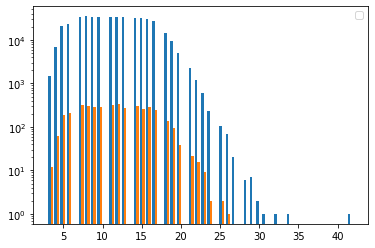

In [52]:
import pandas as pd
test_df = pd.read_csv('/private/000_kdigit/000_teamp/001_dataset/test_no_label.csv')
test_dataset = test_df['Id']

def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

test = make_id_file_test(tokenizer, test_dataset)

class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]
        print(self.data[:10])
            
    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

test_dataset = SentimentTestDataset(tokenizer, test)

[[101, 2009, 1005, 1055, 1037, 2878, 2047, 3325, 1998, 2047, 26389, 2169, 2051, 2017, 2175, 1012, 102], [101, 2061, 15640, 2013, 2019, 2214, 5440, 1012, 102], [101, 2009, 2003, 1996, 2087, 14469, 7273, 1999, 1996, 3028, 1012, 102], [101, 2079, 2025, 3696, 1037, 10084, 2007, 2122, 2111, 1012, 102], [101, 1045, 2001, 6091, 1998, 2016, 2081, 2033, 2514, 2061, 6625, 1998, 6160, 1012, 102], [101, 1996, 2069, 2518, 2057, 2363, 2008, 2001, 2980, 2001, 1996, 4157, 1012, 102], [101, 2053, 1010, 2025, 1996, 3924, 2012, 2004, 2226, 1010, 1996, 3924, 1999, 3502, 2152, 1012, 102], [101, 2027, 3288, 2009, 2041, 2392, 2005, 2017, 1998, 2024, 2200, 14044, 1012, 102], [101, 4606, 1996, 12043, 2106, 1050, 1005, 1056, 2130, 2113, 2129, 2000, 2147, 1996, 3274, 1012, 102], [101, 2027, 2031, 2019, 6581, 4989, 1997, 25025, 2015, 2000, 5454, 2013, 1012, 102]]


In [53]:
test_len = [len(td) for td in test_dataset.data]
test_len

[17,
 9,
 12,
 11,
 15,
 14,
 17,
 14,
 17,
 14,
 8,
 10,
 14,
 10,
 17,
 18,
 17,
 11,
 12,
 15,
 12,
 10,
 16,
 12,
 17,
 11,
 13,
 12,
 18,
 15,
 15,
 10,
 11,
 15,
 13,
 10,
 15,
 14,
 15,
 12,
 10,
 16,
 15,
 14,
 16,
 17,
 13,
 18,
 19,
 11,
 10,
 9,
 13,
 12,
 9,
 17,
 14,
 17,
 13,
 16,
 8,
 9,
 9,
 16,
 9,
 14,
 12,
 13,
 20,
 11,
 16,
 18,
 14,
 15,
 9,
 8,
 20,
 16,
 17,
 16,
 10,
 12,
 16,
 9,
 17,
 11,
 11,
 13,
 17,
 8,
 10,
 11,
 12,
 14,
 8,
 13,
 15,
 19,
 13,
 14,
 16,
 8,
 15,
 8,
 13,
 21,
 8,
 15,
 11,
 8,
 15,
 11,
 12,
 17,
 15,
 16,
 10,
 11,
 17,
 10,
 14,
 10,
 9,
 11,
 14,
 14,
 10,
 13,
 13,
 16,
 14,
 9,
 10,
 11,
 9,
 11,
 8,
 11,
 10,
 13,
 11,
 13,
 17,
 10,
 9,
 10,
 14,
 14,
 17,
 13,
 11,
 12,
 13,
 19,
 14,
 17,
 15,
 14,
 8,
 15,
 13,
 8,
 14,
 14,
 15,
 17,
 13,
 10,
 10,
 14,
 15,
 13,
 22,
 10,
 9,
 11,
 11,
 9,
 17,
 15,
 13,
 10,
 17,
 16,
 12,
 11,
 16,
 14,
 12,
 11,
 12,
 21,
 9,
 10,
 8,
 17,
 13,
 16,
 17,
 12,
 14,
 9,
 13,
 9,
 8,
 10,
 

No handles with labels found to put in legend.


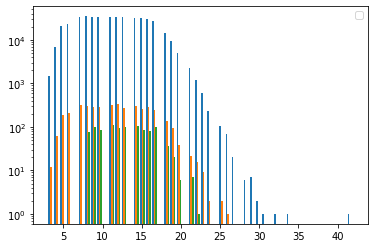

In [48]:
plt.hist((train_len, dev_len, test_len), bins=50, histtype='bar', log=True)
plt.legend()